In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

# EDA

Загрузим датасет

In [2]:
url = 'https://data.open-power-system-data.org/time_series/2020-10-06/'
datafile = url + 'time_series_60min_singleindex.csv'
df_all = pd.read_csv(datafile, index_col='utc_timestamp', parse_dates=True, low_memory=False)

Очистим данные от timezone

In [3]:
df_all.index = df_all.index.tz_localize(None)

In [4]:
df_all.head()

cet_cest_timestamp  \
utc_timestamp                                   
2014-12-31 23:00:00  2015-01-01T00:00:00+0100   
2015-01-01 00:00:00  2015-01-01T01:00:00+0100   
2015-01-01 01:00:00  2015-01-01T02:00:00+0100   
2015-01-01 02:00:00  2015-01-01T03:00:00+0100   
2015-01-01 03:00:00  2015-01-01T04:00:00+0100   

                     AT_load_actual_entsoe_transparency  \
utc_timestamp                                             
2014-12-31 23:00:00                                 NaN   
2015-01-01 00:00:00                              5946.0   
2015-01-01 01:00:00                              5726.0   
2015-01-01 02:00:00                              5347.0   
2015-01-01 03:00:00                              5249.0   

                     AT_load_forecast_entsoe_transparency  AT_price_day_ahead  \
utc_timestamp                                                                   
2014-12-31 23:00:00                                   NaN                 NaN   
2015-01-01 00:00:00                                6701.0                35.0   
2015-01-01 01:00:00                                6593.0                45.0   
2015-01-01 02:00:00                                6482.0                41.0   
2015-01-01 03:00:00                                6454.0                38.0   

                     AT_solar_generation_actual  \
utc_timestamp                                     
2014-12-31 23:00:00                         NaN   
2015-01-01 00:00:00                         NaN   
2015-01-01 01:00:00                         NaN   
2015-01-01 02:00:00                         NaN   
2015-01-01 03:00:00                         NaN   

                     AT_wind_onshore_generation_actual  \
utc_timestamp                                            
2014-12-31 23:00:00                                NaN   
2015-01-01 00:00:00                               69.0   
2015-01-01 01:00:00                               64.0   
2015-01-01 02:00:00                               65.0   
2015-01-01 03:00:00                               64.0   

                     BE_load_actual_entsoe_transparency  \
utc_timestamp                                             
2014-12-31 23:00:00                                 NaN   
2015-01-01 00:00:00                              9484.0   
2015-01-01 01:00:00                              9152.0   
2015-01-01 02:00:00                              8799.0   
2015-01-01 03:00:00                              8567.0   

                     BE_load_forecast_entsoe_transparency  \
utc_timestamp                                               
2014-12-31 23:00:00                                   NaN   
2015-01-01 00:00:00                                9897.0   
2015-01-01 01:00:00                                9521.0   
2015-01-01 02:00:00                                9135.0   
2015-01-01 03:00:00                                8909.0   

                     BE_solar_generation_actual  BE_wind_generation_actual  \
utc_timestamp                                                                
2014-12-31 23:00:00                         NaN                        NaN   
2015-01-01 00:00:00                         NaN                        NaN   
2015-01-01 01:00:00                         NaN                     734.81   
2015-01-01 02:00:00                         NaN                     766.64   
2015-01-01 03:00:00                         NaN                     733.13   

                     ...  SI_load_actual_entsoe_transparency  \
utc_timestamp        ...                                       
2014-12-31 23:00:00  ...                                 NaN   
2015-01-01 00:00:00  ...                                 NaN   
2015-01-01 01:00:00  ...                             1045.47   
2015-01-01 02:00:00  ...                             1004.79   
2015-01-01 03:00:00  ...                              983.79   

                     SI_load_forecast_entsoe_transparency  \
utc_timestamp                        

In [5]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    """Extract data for a single country"""

    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]

    # Extract columns and remove country codes from column labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)

    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]

    return df_out

def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    df = df / 1000
#     df = df.groupby(df.index.hour).mean()
    df = df.rename_axis('Date')

    return df

Для анализа была выбрана Испания

In [6]:
df_hrly = extract_country(df_all, country_code='ES', year_min=2015, year_max=2020)
df_hrly.sample(3)


load_actual_entsoe_transparency  \
utc_timestamp                                          
2018-02-07 11:00:00                          38876.0   
2019-01-01 04:00:00                          19161.0   
2016-10-16 10:00:00                          24280.0   

                     load_forecast_entsoe_transparency  \
utc_timestamp                                            
2018-02-07 11:00:00                            38680.0   
2019-01-01 04:00:00                            19547.0   
2016-10-16 10:00:00                            24461.0   

                     solar_generation_actual  wind_onshore_generation_actual  
utc_timestamp                                                                 
2018-02-07 11:00:00                   3625.0                          7398.0  
2019-01-01 04:00:00                     15.0                          3384.0  
2016-10-16 10:00:00                   2750.0                          3755.0

In [7]:
cols_map = {'load_actual_entsoe_transparency' : 'Consumption',
            'wind_onshore_generation_actual' : 'Wind',
            'solar_generation_actual' : 'Solar'}
df = transform_dataframe(df_hrly, cols_map).dropna()

Проведем предварительный анализ

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50373 entries, 2015-01-01 01:00:00 to 2020-09-30 22:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  50373 non-null  float64
 1   Wind         50373 non-null  float64
 2   Solar        50373 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


In [9]:
# Preliminary Analysis
df.sample(10)

Consumption    Wind  Solar
Date                                           
2018-06-12 07:00:00       30.960   3.676  2.211
2015-02-25 18:00:00       36.177  12.943  0.590
2015-06-11 06:00:00       30.206   2.621  0.351
2015-06-29 15:00:00       36.539   3.776  4.632
2018-07-17 21:00:00       30.270   6.032  0.595
2015-03-29 20:00:00       27.455   7.901  0.682
2020-04-16 10:00:00       27.877   9.265  4.464
2020-07-09 08:00:00       33.632   1.506  6.170
2019-03-01 06:00:00       30.167   2.690  0.015
2018-03-05 11:00:00       36.215   8.496  1.501

Добавим общее производство "зеленой" энергии


In [10]:
# df wind + solar generation
df['Green'] = df[['Wind', 'Solar']].sum(axis=1, skipna=False)
df.to_csv('es_clf_data.csv')
df.head()

Consumption   Wind  Solar  Green
Date                                                 
2015-01-01 01:00:00       22.734  5.461  0.050  5.511
2015-01-01 02:00:00       21.286  5.238  0.050  5.288
2015-01-01 03:00:00       20.264  4.935  0.042  4.977
2015-01-01 04:00:00       19.905  4.618  0.034  4.652
2015-01-01 05:00:00       20.010  4.397  0.034  4.431


Добавим общее производство искапаемой энергии




In [11]:
df['Fossil'] = df['Consumption'] - df['Green']
df.head()

Consumption   Wind  Solar  Green  Fossil
Date                                                         
2015-01-01 01:00:00       22.734  5.461  0.050  5.511  17.223
2015-01-01 02:00:00       21.286  5.238  0.050  5.288  15.998
2015-01-01 03:00:00       20.264  4.935  0.042  4.977  15.287
2015-01-01 04:00:00       19.905  4.618  0.034  4.652  15.253
2015-01-01 05:00:00       20.010  4.397  0.034  4.431  15.579

Визуализируем наши данные

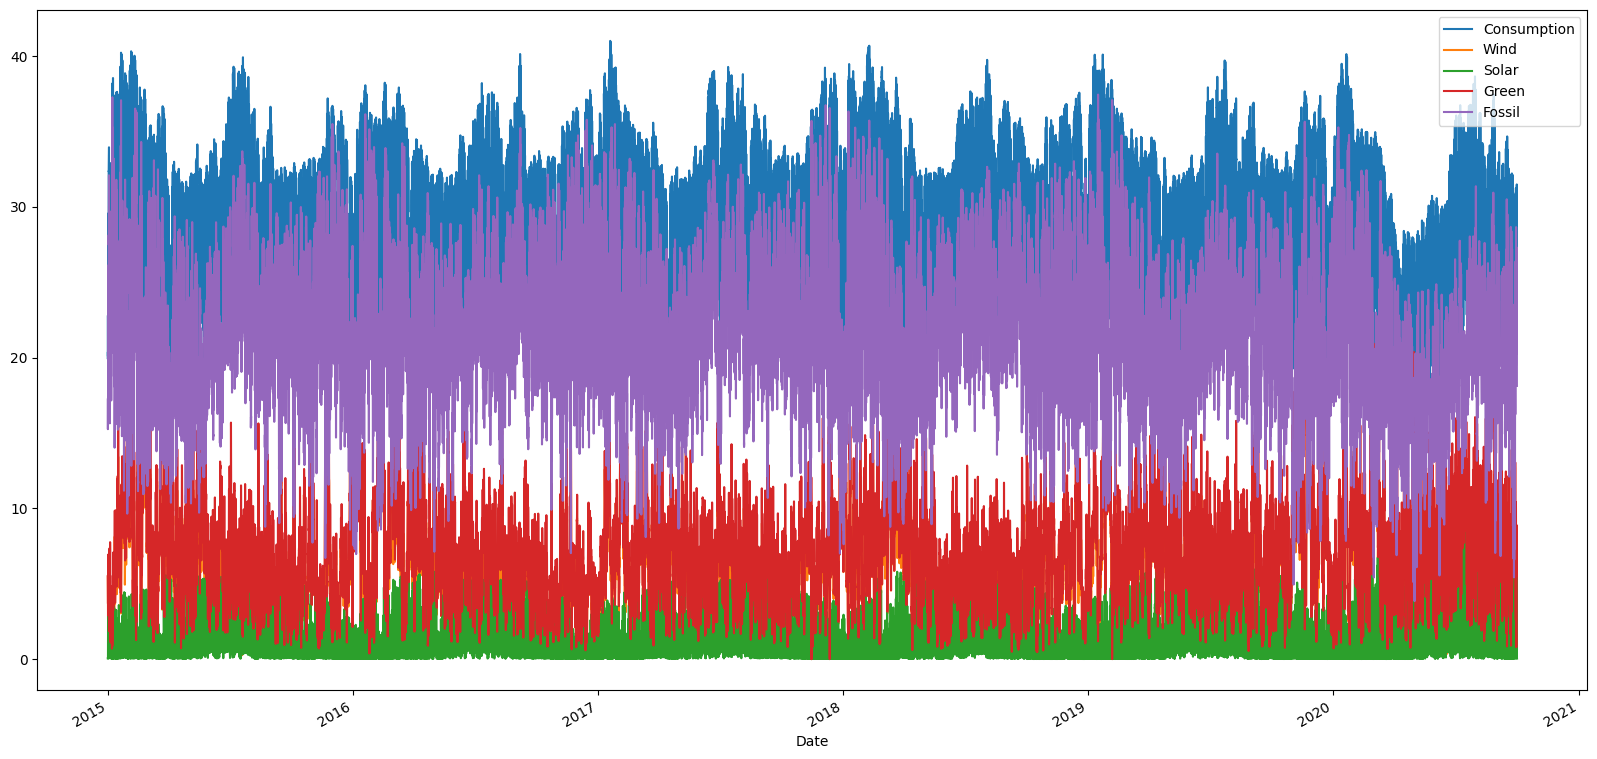

In [12]:
# Visualize the time series
df.plot(figsize=(20, 10))
plt.show()


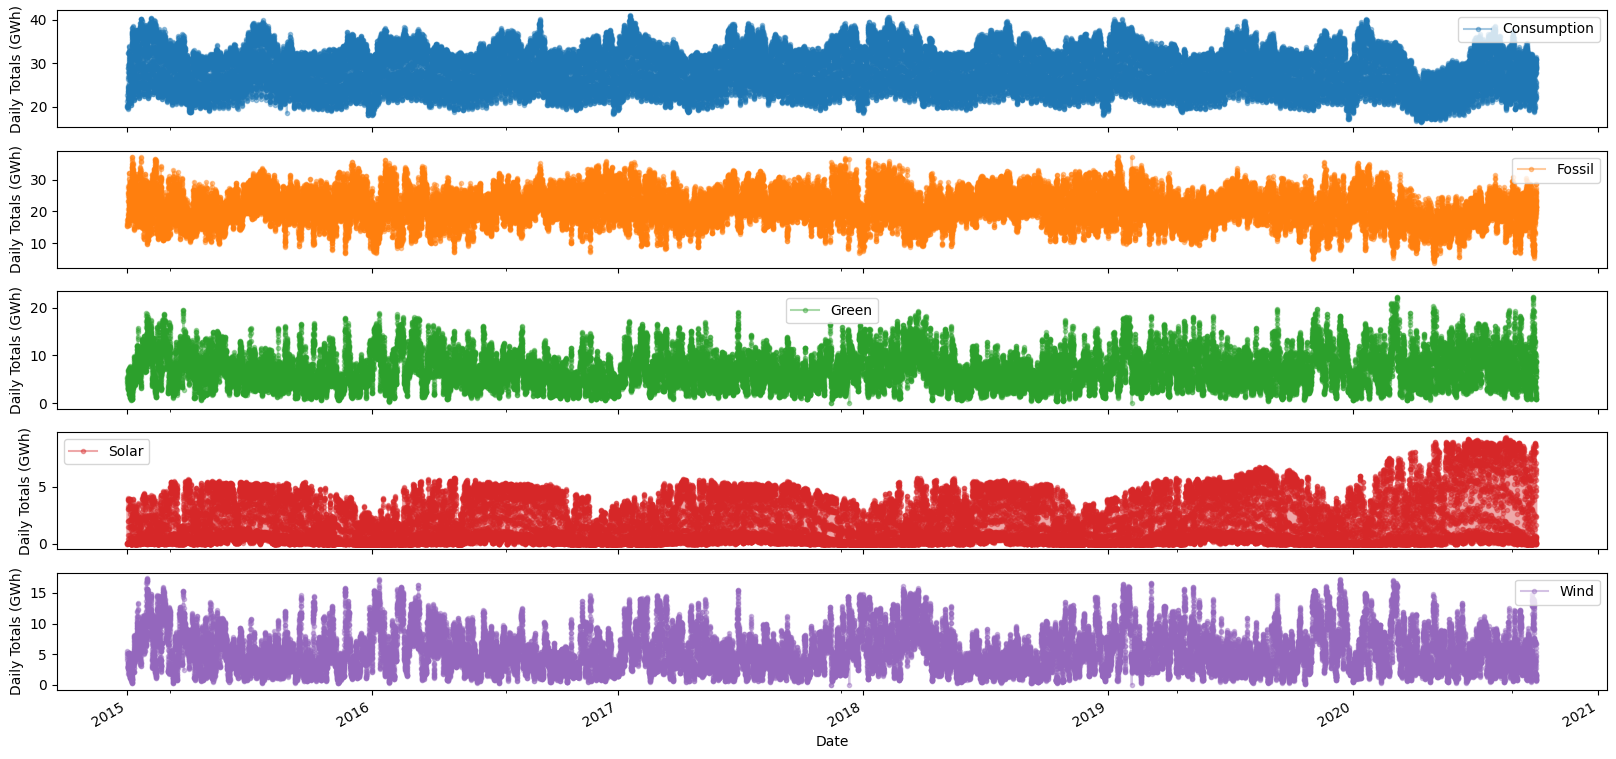

In [13]:
cols_plot = ['Consumption','Fossil', 'Green', 'Solar', 'Wind',]
axes = df[cols_plot].plot(marker='.', alpha=0.4, linestyle='-', figsize=(20, 10), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

Визуализируем производство зеленой энергии и общего потребления

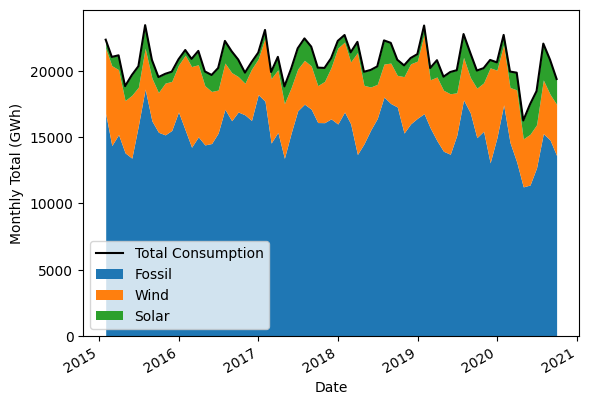

In [14]:
import matplotlib.dates as mdates
df_monthly = df.resample('M').sum(min_count=7)


fig, ax = plt.subplots()
ax.plot(df_monthly['Consumption'], color='black', label='Total Consumption')

df_monthly[['Fossil', 'Wind', 'Solar', ]].plot.area(ax=ax, linewidth=0)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Monthly Total (GWh)');

В данных есть что-то похожее не сезонность

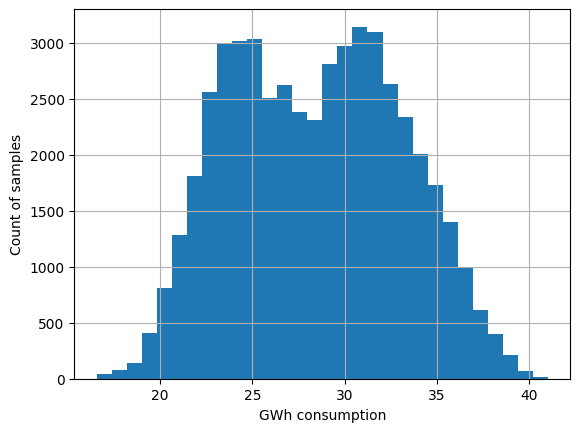

In [15]:
ax = df.Consumption.hist(bins=30)

ax.set_ylabel('Count of samples')
ax.set_xlabel('GWh consumption')
plt.show()

График распределения потребления двухмодальный. Пики потребления около 24-25 ГВт и 31-32 ГВт

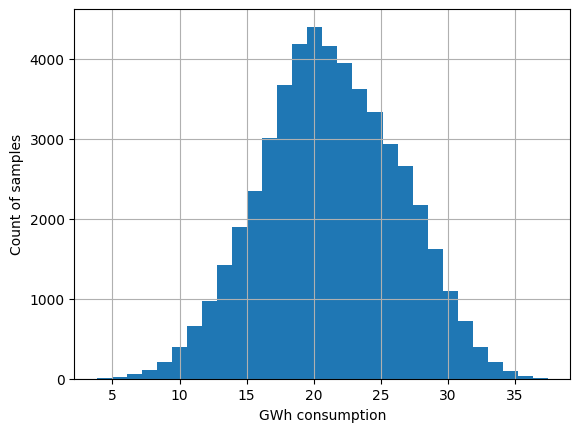

In [16]:
ax = df.Fossil.hist(bins=30)

ax.set_ylabel('Count of samples')
ax.set_xlabel('GWh consumption')
plt.show()

График производства эниргии из ископаемых источников похож на нормальный

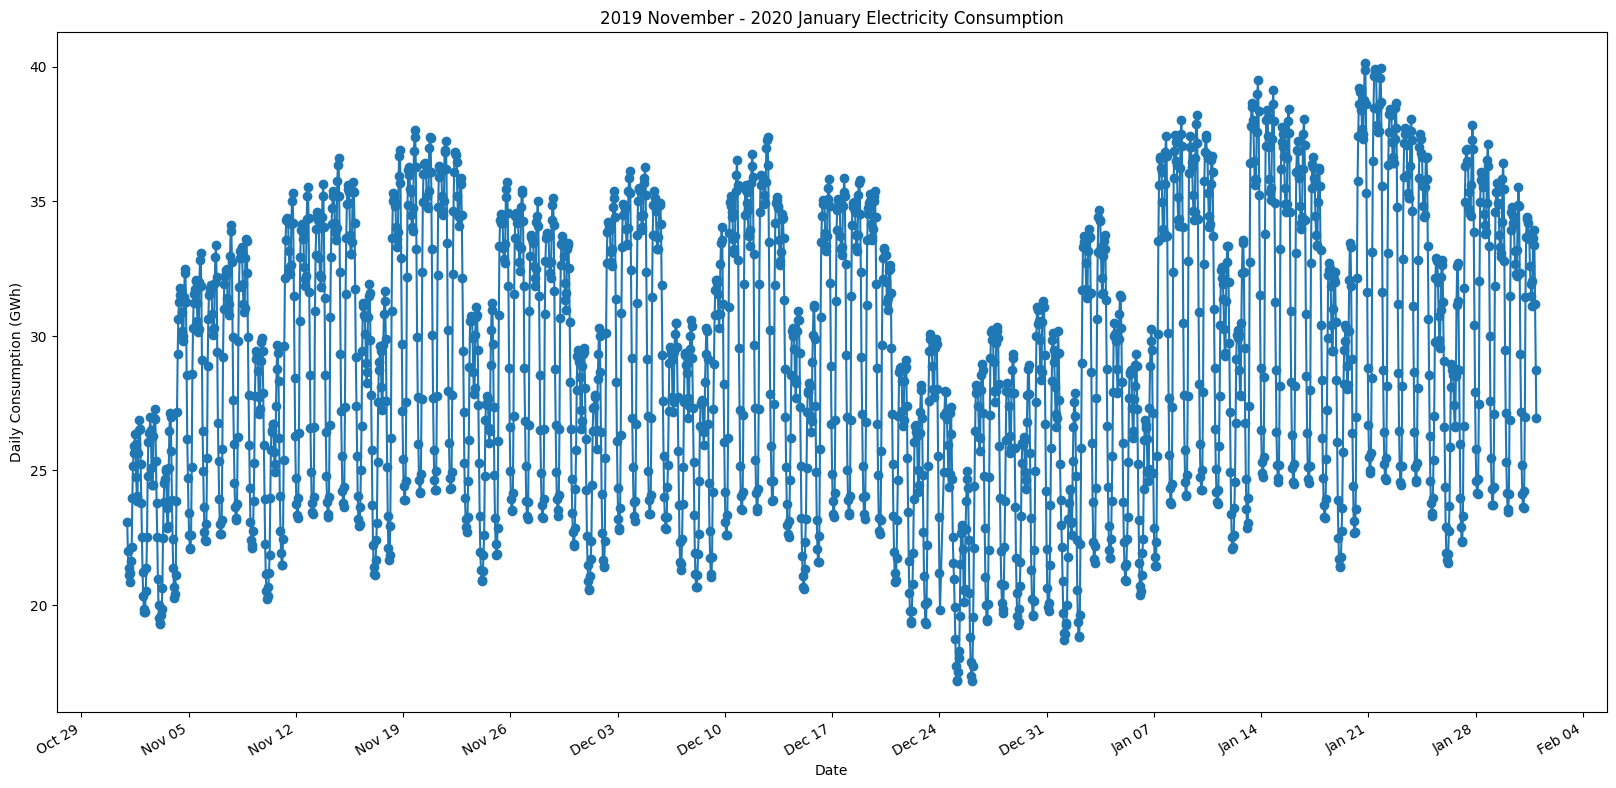

In [17]:
ax = df.loc['2019-11':'2020-01', 'Consumption'].plot(marker='o', linestyle='-', figsize=(20, 10))
ax.set_ylabel('Daily Consumption (GWh)')
ax.set_title('2019 November - 2020 January Electricity Consumption')

# For more convinient ticks (week ticks)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
# Format 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.show()

Спад потребления выпадает на выходные дни и праздники (католическое рождество, и новый год)



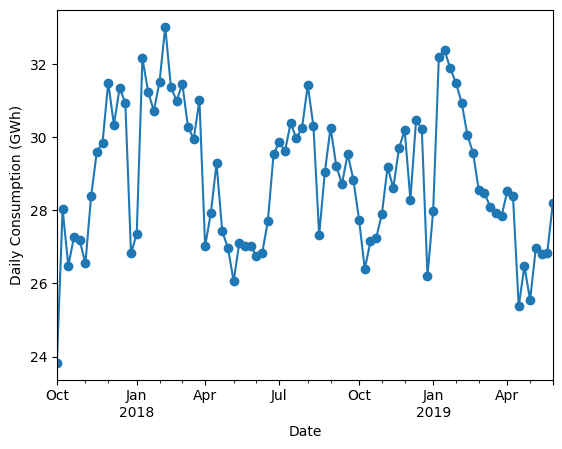

In [18]:
ax = df.loc['2017-10':'2019-05', 'Consumption'].resample('W').mean().plot(marker='o', linestyle='-',linewidth=1.5)
ax.set_ylabel('Daily Consumption (GWh)')
plt.show()

По графику скользящей средней видно, что имеется несколько минимумов потребления:
- май
- октябрь
- декабрь

Если обратиться к графику национальных праздничных дней в Испании, то они выпадают на эти месяцы

<Axes: xlabel='Date'>

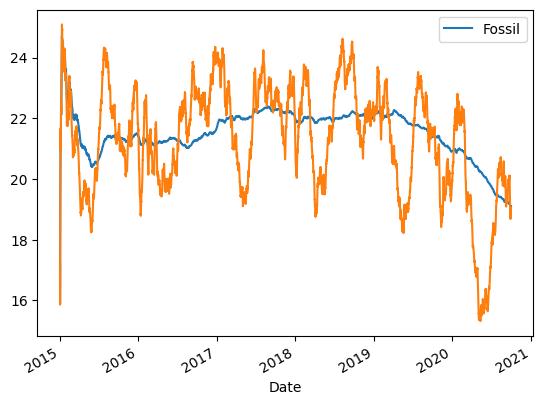

In [19]:
df[['Fossil']].rolling('365d').mean().plot( linewidth=1.5, );
df.Fossil.ewm(halflife=365, min_periods=0,adjust=True).mean().plot()

В последние годы производство энергии из ископаемых источников топлива снижается, так-же на потребление не мог не повлиять COVID-19

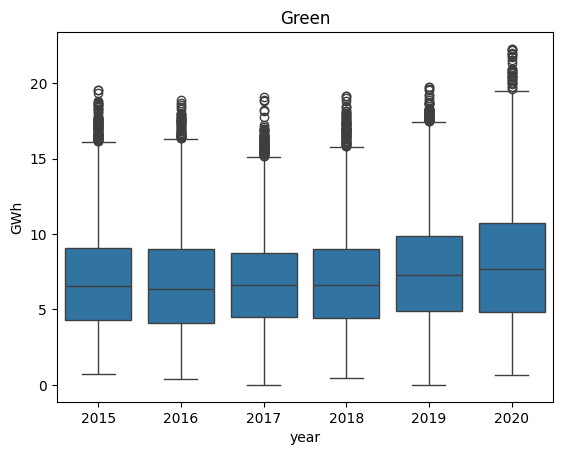

In [20]:
ax = sns.boxplot(data=df, x=df.index.year, y='Green')
ax.set_ylabel('GWh')
ax.set_xlabel('year')
ax.set_title('Green')
plt.show()


Наблюдается довольно большое количество выбросов, что скорее всего свидетельствует о очень солнечных днях и очень ветрянных днях.

<Axes: xlabel='Date'>

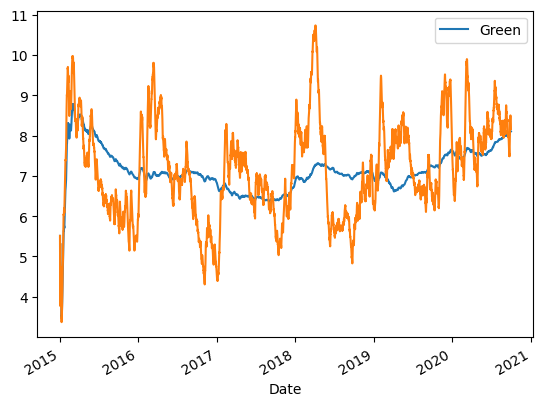

In [21]:
df[['Green']].rolling('365d').mean().plot( linewidth=1.5, )
df.Green.ewm(halflife=365, min_periods=0,adjust=True).mean().plot()

Производство энергии из возобновляемых источников напротив растет, выросло даже в период локдаунов

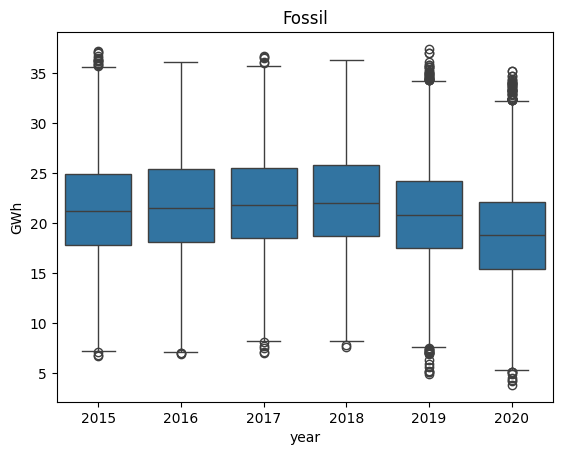

In [22]:
ax = sns.boxplot(data=df, x=df.index.year, y='Fossil')
ax.set_ylabel('GWh')
ax.set_xlabel('year')
ax.set_title('Fossil')
plt.show()


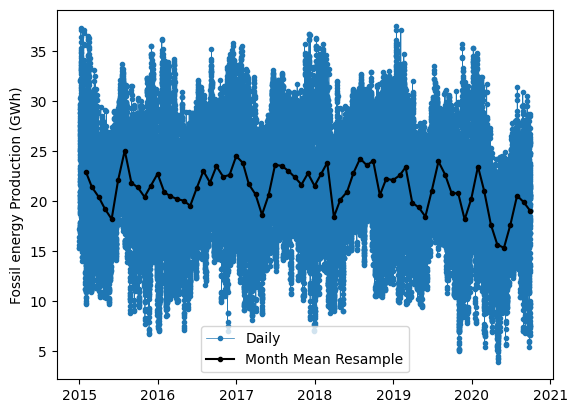

In [23]:
start, end = '2015-01', '2020-12'

fig, ax = plt.subplots()
ax.plot(df.loc[start:end, 'Fossil'],marker='.', linestyle='-', linewidth=0.5, label='Daily', )
ax.plot(df.resample('M').mean().loc[start:end, 'Fossil'], marker='o', markersize=3, linestyle='-', label='Month Mean Resample', color='k')
ax.set_ylabel('Fossil energy Production (GWh)')
ax.legend()

Вероятно сезонность следует за общим потреблением энегрии, проверим дополнительно с помощью boxplot

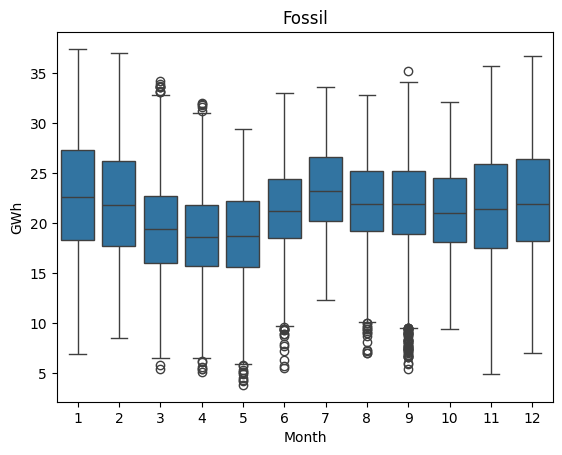

In [24]:
ax = sns.boxplot(data=df, x=df.index.month, y='Fossil')
ax.set_ylabel('GWh')
ax.set_xlabel('Month')
ax.set_title('Fossil')
plt.show()

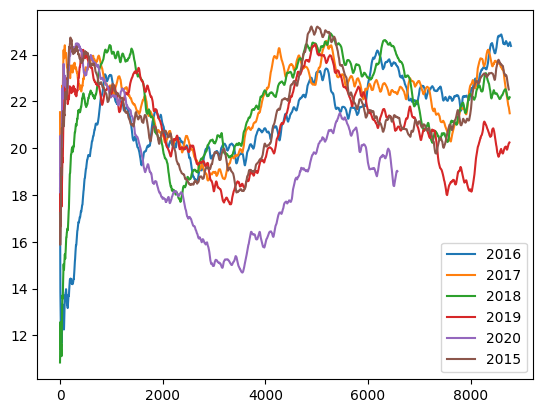

In [25]:
for year in list(set(df.index.year)):
    plt.plot(df.loc[str(year):str(year), 'Fossil'].rolling('30d').mean().values, label=year)

plt.legend()

Какие-то пересечения есть, но с уверенностью сказать нельзя

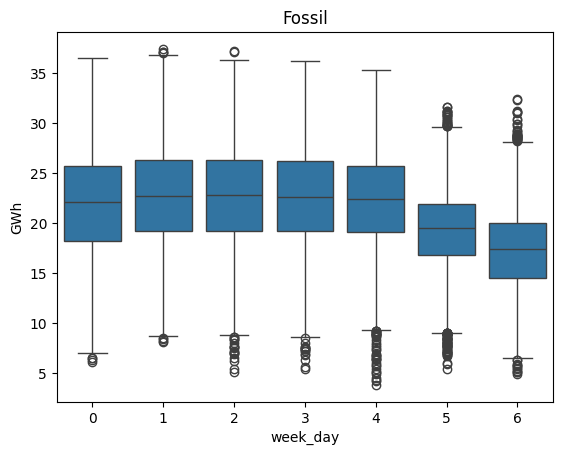

In [26]:
ax = sns.boxplot(data=df, x=df.index.weekday, y='Fossil');
ax.set_ylabel('GWh')
ax.set_xlabel('week_day')
ax.set_title('Fossil')
plt.show()

Производство ископаемой энергии в выходные наглядно ниже чем в будние дни

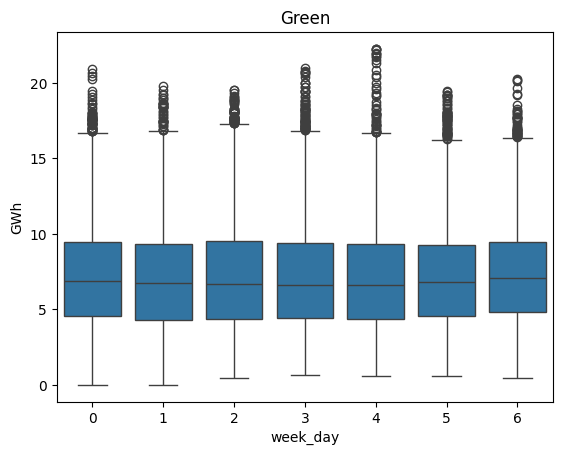

In [27]:
ax = sns.boxplot(data=df, x=df.index.weekday, y='Green')
ax.set_ylabel('GWh')
ax.set_xlabel('week_day')
ax.set_title('Green')
plt.show()

Производство энергии из возобновляемых источников ровное  по неделе

# Попробуем провести предсказания

Обновим библиотеку SKTime и импортируем её

In [29]:
import sktime

In [30]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [31]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster

from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
warnings.simplefilter("ignore", FutureWarning)
%matplotlib inline

In [32]:
def fenn_forbes_index(y_test, y_pred):
  """Индекс Фенна-Форбса (Fenn Forbes Index):"""
  n = len(y_test)
  error = y_test - y_pred
  mean_y_test = np.mean(y_test)
  sse = np.sum((y_test - mean_y_test) ** 2)
  ssr = np.sum(error ** 2)
  fenn_forbes = 1 - (ssr / sse)
  return fenn_forbes
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

Создадим backup датасета

In [33]:
df_bk = df.copy()

Выберем столбец потребления энергии из ископаемых источников в качестве отдельного временного ряда.

В ходе анализа было установлено, что ряд имеет как минимум 2 составляющие (незначительную быструю, с периодом неделя и медленную с периодом 1 год). Для упрощения анализа удалим быструю составляющую.

In [34]:
y = df.Fossil.asfreq('7d')
y.head()

Date
2015-01-01 01:00:00    17.223
2015-01-08 01:00:00    23.002
2015-01-15 01:00:00    15.900
2015-01-22 01:00:00    15.501
2015-01-29 01:00:00    16.108
Freq: 7D, Name: Fossil, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Fossil'>)

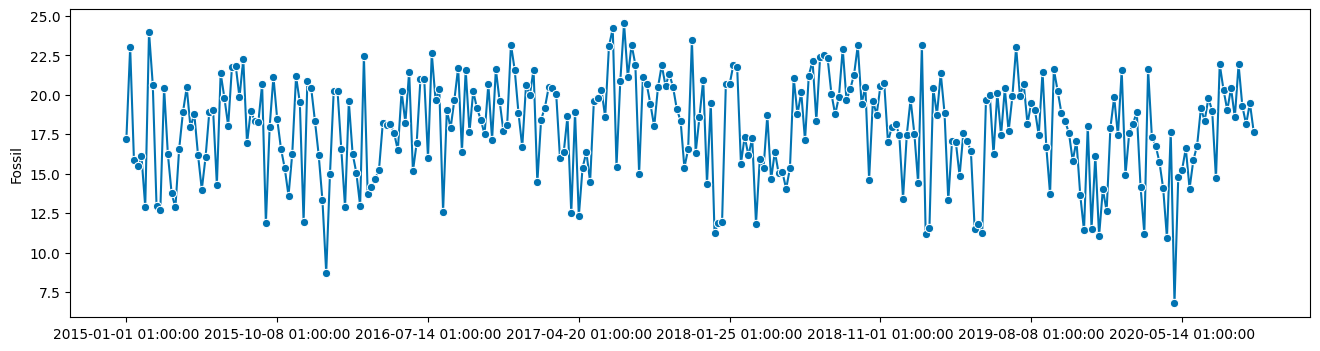

In [35]:
sktime.utils.plotting.plot_series(y)

Разобьем данные на тренировочную и тестовую выборки

Check splitted data size: Train: 180, Test: 120


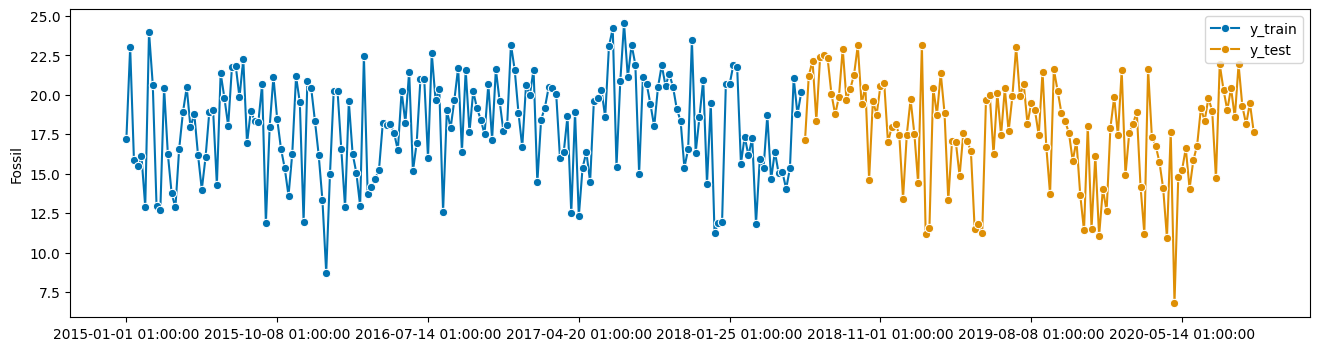

In [36]:
TEST_SIZE = int(0.4 * y.size)

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

sktime.utils.plotting.plot_series(y_train, y_test, labels=["y_train", "y_test"]);

## Наивное сезонное предсказание

sMAPE = 0.145


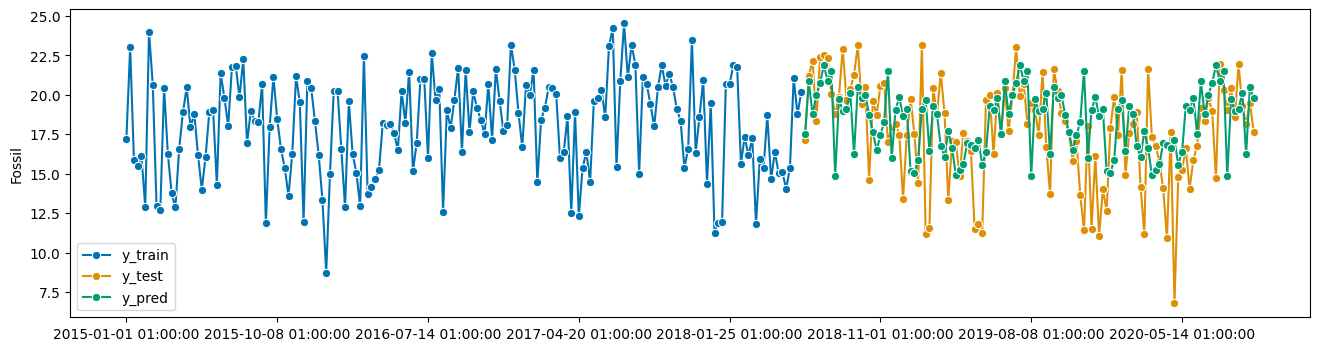

In [37]:
SEASON = 52 # 52 Недели в году
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy="mean", sp=SEASON)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

**sMAPE=0.145** - означает, что в среднем абсолютная процентная ошибка между прогнозируемыми значениями и фактическими значениями составляет 14,5%. 

Это относительно низкое значение sMAPE, указывающее на то, что модель прогнозирования неплохо справляется с предсказаниями.

## Exponential Smoothing, Holt-Winter

sMAPE = 0.144


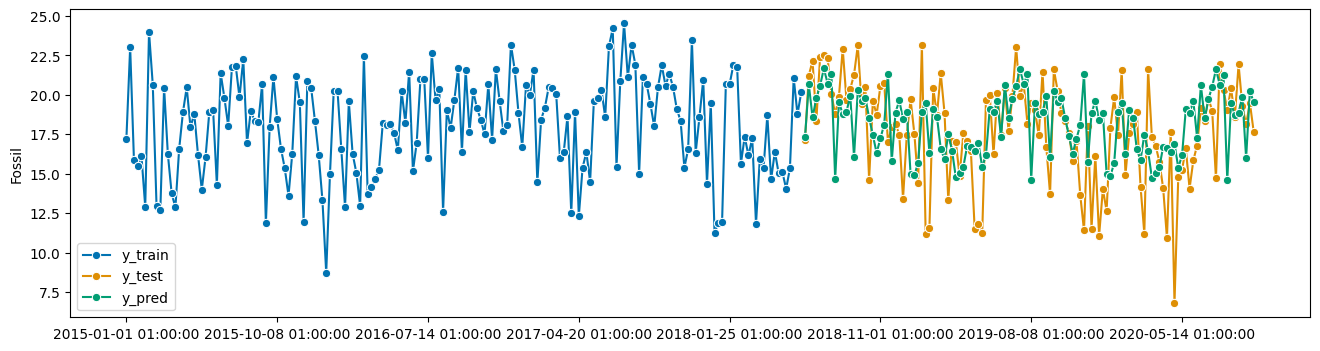

In [38]:
SEASON = 52

ses         = ExponentialSmoothing(sp=SEASON)
holt        = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
damped_holt = ExponentialSmoothing(trend="add", damped_trend=True,   sp=SEASON)
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)



forecaster = holt_winter

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Результат чуть лучше чем у наивного предсказания **sMAPE = 0.144**

## KNN

sMAPE = 0.190


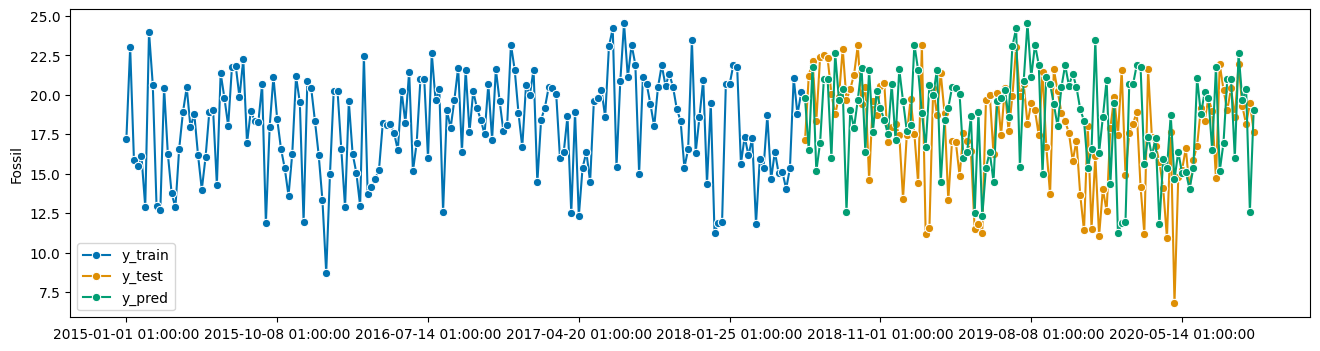

In [39]:
from sklearn.neighbors import KNeighborsRegressor

REGRESSION_WINDOW = 15
N_NEIGHBOURS = 3

regressor  = KNeighborsRegressor(n_neighbors=N_NEIGHBOURS)
forecaster = make_reduction(regressor, window_length=REGRESSION_WINDOW, strategy="recursive")

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Результат хуже чем у наивного предсказания **sMAPE = 0.190**

## ThetaForecaster

Метод предсказания временных рядов на основе экспоненциального сглаживания

sMAPE = 0.155


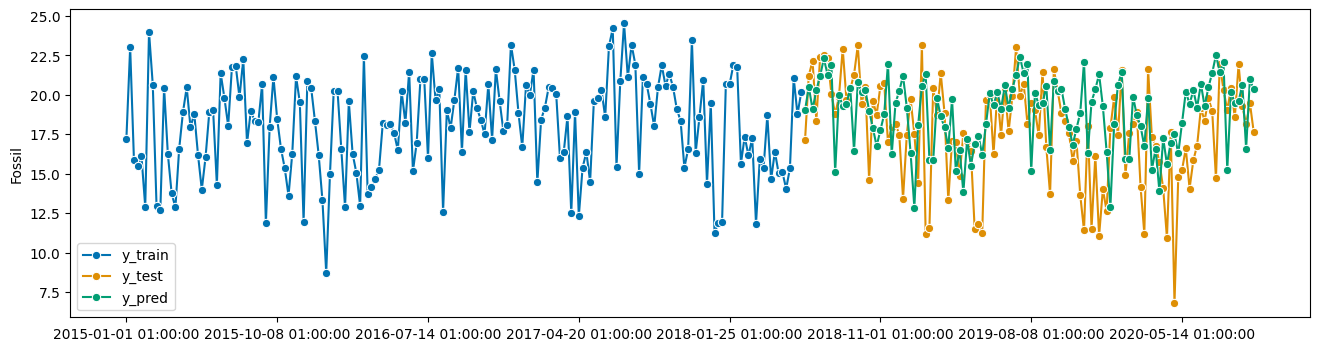

In [40]:
forecaster = ThetaForecaster(sp=SEASON)
# Для модели с дрейфом тренда (случайный тренд).
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Результат хуже чем у наивного предсказания **sMAPE = 0.155**

## Prophet

/home/dzailz/urfu/MFoML/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
00:24:33 - cmdstanpy - INFO - Chain [1] start processing
00:24:33 - cmdstanpy - INFO - Chain [1] done processing


sMAPE = 0.146
MAE = 2.482
MSE = 11.282
RMSE = 3.359
Fenn Forbes Index = -0.083
R-squared = -0.083


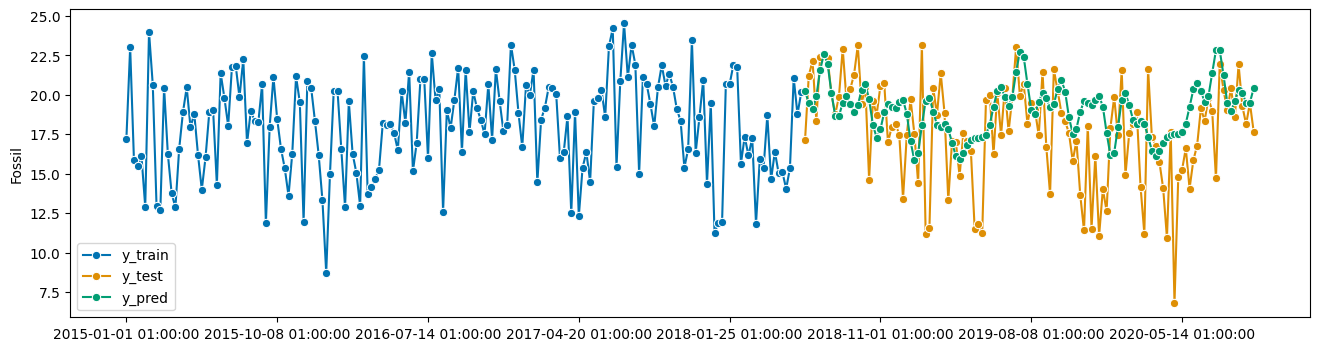

In [41]:
forecaster = Prophet(
                    seasonality_mode='additive',
                    n_changepoints=int(len(y_train) / 1),
                    add_country_holidays={'country_name': 'Spain'},
                    yearly_seasonality=True,
                    )

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
print(f'MAE = {mean_absolute_error(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')
print(f'RMSE = {mean_squared_error(y_test, y_pred, squared=False):.3f}')
print(f'Fenn Forbes Index = {fenn_forbes_index(y_test, y_pred):.3f}')
print(f'R-squared = {r2_score(y_test, y_pred):.3f}')

sMAPE = 0.146

# Выбор параметров модели SARIMA и сравнение выбранных методов предсказаний и результатов работы настроенной модели.

In [42]:
from statsmodels.tsa.stattools import adfuller
from sktime.utils.plotting import plot_series
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon

import pmdarima as pm
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

Проверим стационарность ряда

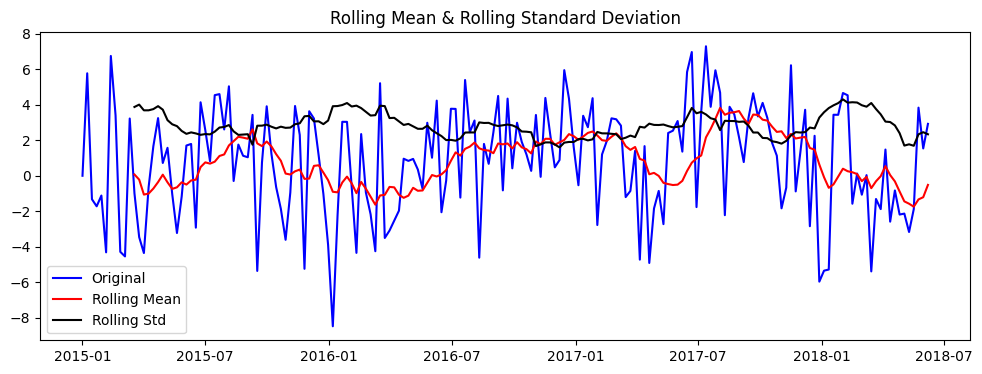

In [43]:
rolling_mean = y_train.rolling(window = 12).mean()
rolling_std  = y_train.rolling(window = 12).std()
plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_train-y_train[0],      color = 'blue',  label = 'Original')
plt.plot(rolling_mean-y_train[0], color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,             color = 'black', label = 'Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [44]:
P_THRESHOLD = 0.05
def check_ADF(y, p_threshold = P_THRESHOLD):
    result = adfuller(y)
    adf_value = result[0]
    p_value   = result[1]
    print('ADF Statistic: {:.4f}'.format(adf_value))
    print('p value:', p_value)
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value>value else ""))
    print(f'Result: The series is {"not " if p_value < p_threshold else ""}stationary')
    return result

check_ADF(y_train, p_threshold = P_THRESHOLD);

ADF Statistic: -10.7392
p value: 2.8475589817343224e-19
Critical Values:
	1%: -3.4674, 
	5%: -2.8778, 
	10%: -2.5755, 
Result: The series is not stationary


Ряд не стационарен

Попробуем добиться стационарности классическим дифференцированием

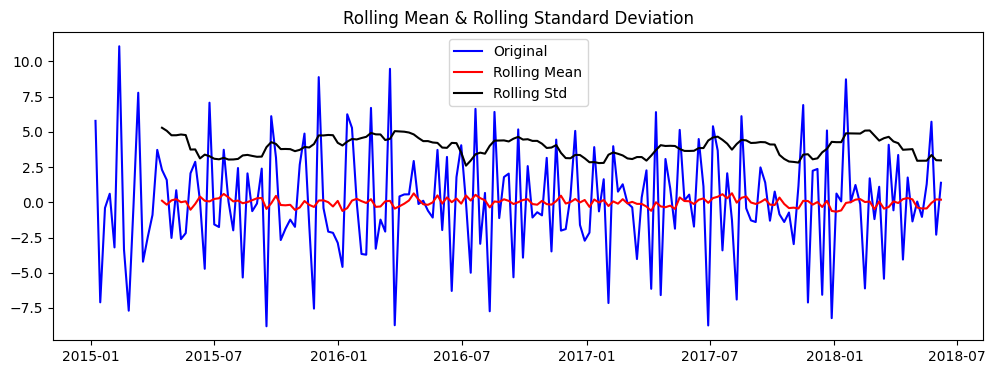

ADF Statistic: -7.6360
p value: 1.951644789432143e-11
Critical Values:
	1%: -3.4694, 
	5%: -2.8787, 
	10%: -2.5759, 
Result: The series is not stationary


In [45]:
y_diff = y_train[:].diff(1).dropna()

rolling_mean = y_diff.rolling(window = 15).mean()
rolling_std  = y_diff.rolling(window = 15).std()

plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_diff,       color = 'blue',  label = 'Original')
plt.plot(rolling_mean, color = 'red',   label = 'Rolling Mean')
plt.plot(rolling_std,  color = 'black', label = 'Rolling Std')

plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

result = check_ADF(y_diff)

Попробуем сезонное дифференцирование

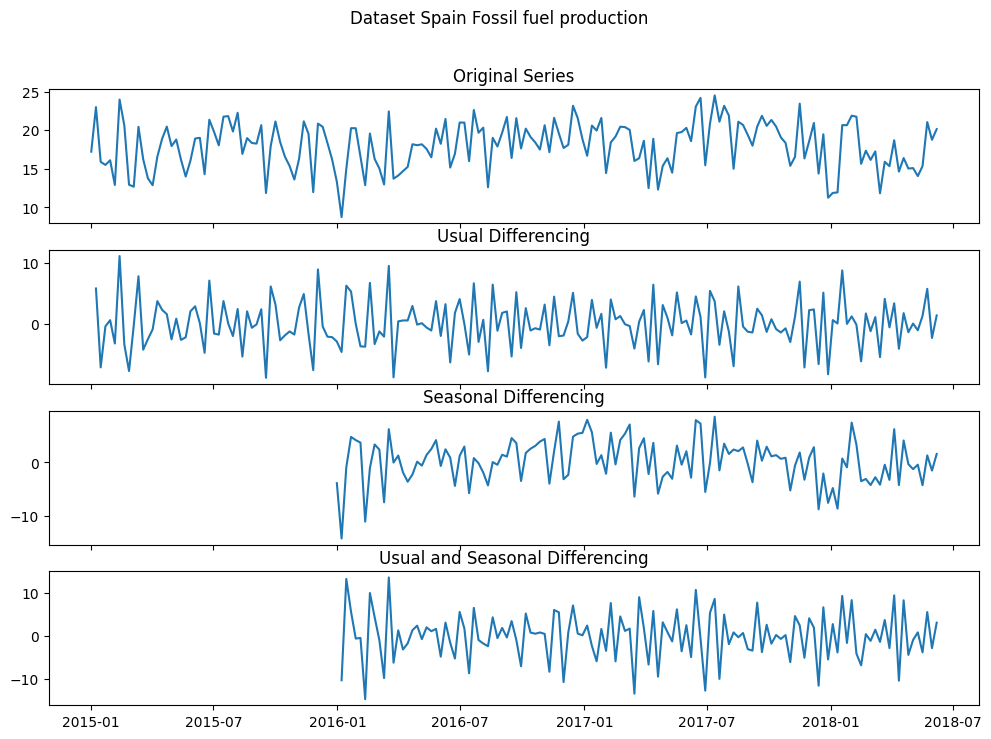

In [46]:
SEASON = 52

# Plot
fig, axes = plt.subplots(4, 1, figsize=(12,8), dpi=100, sharex=True)

# Original Series
axes[0].plot(y_train[:])
axes[0].set_title('Original Series')

# Usual Differencing
axes[1].plot(y_train[:].diff(1))
axes[1].set_title('Usual Differencing')

# Seasinal Differencing
axes[2].plot(y_train[:].diff(SEASON))
axes[2].set_title('Seasonal Differencing')

# Seasinal and Usual Differencing
axes[3].plot(y_train[:].diff(1).diff(SEASON))
axes[3].set_title('Usual and Seasonal Differencing')

plt.suptitle('Dataset Spain Fossil fuel production', fontsize=12)
plt.show()

In [47]:
y_sdif = y_train[:].diff(1).diff(SEASON).dropna()
results = check_ADF(y_sdif)

ADF Statistic: -8.1638
p value: 8.993976008974345e-13
Critical Values:
	1%: -3.4865, 
	5%: -2.8862, 
	10%: -2.5799, 
Result: The series is not stationary


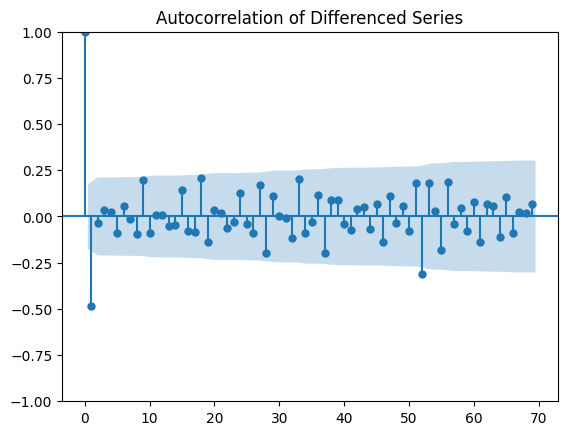

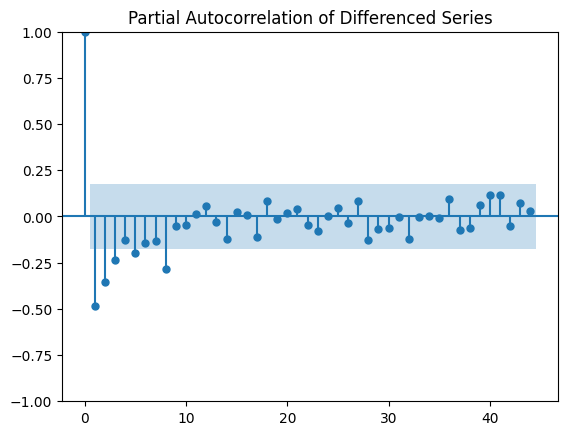

In [48]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Usual Differencing
plot_acf(y_sdif, title='Autocorrelation of Differenced Series', lags=np.arange(70) )
plt.show()
# Usual Differencing
plot_pacf(y_sdif, title='Partial Autocorrelation of Differenced Series', method='ywm', lags=np.arange(45))
plt.show()

In [74]:
forecaster = SARIMAX(order=(5, 1, 0), seasonal_order=(0, 1, 0, SEASON))             # Указываем порядок модели как (3, 1, 0), что означает,
forecaster.fit(y_train)                                                         # Сезонный порядок задается как (0, 1, 0, 52), где у вас есть сезонная разность (I) с периодом 52 недели.
print(forecaster.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03613D+00    |proj g|=  4.59482D-02

At iterate    5    f=  2.03152D+00    |proj g|=  8.50988D-03

At iterate   10    f=  2.03137D+00    |proj g|=  8.62324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     14     17      1     0     0   4.565D-06   2.031D+00
  F =   2.0313731096080700     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                  

## SARIMAX report conclusion:

На основе вывода модели SARIMAX для временного ряда, связанного с переменной 'Fossil', можно сделать несколько выводов:
1. Соответствие Модели: Модель, по-видимому, хорошо подходит к данным. Это
указывает значение Логарифмического Правдоподобия, хотя для более полной оценки необходимо сравнение с другими моделями или базовыми значениями.    
2. Статистическая Значимость: Коэффициенты авторегрессионных членов (ar.L1, ar.L2, ar.L3) статистически значимы, как следует из их p-значений (все меньше 0.05). Это подразумевает, что прошлые значения переменной 'Fossil' имеют значительное влияние на её будущие значения.    
3. Сезонность: Сезонная составляющая модели (0, 1, 0, 52) указывает на значительное сезонное влияние с годовой периодичностью (52 недели в году). Это предполагает, что переменная 'Fossil' имеет явный годовой паттерн.
4. Тренд и Дифференцирование: В модель включено дифференцирование (d=1 и D=1), что указывает на то, что данные были дифференцированы для их стационаризации. Это обычная практика при работе с временными рядами, показывающими тенденции или сезонность.
5. Анализ Остатков: Диагностика, такая как тест Льюнга-Бокса и тест Жарка-Бера, показывает, что остатки (различия между наблюдаемыми значениями и значениями, предсказанными моделью) ведут себя хорошо. Это означает, что ошибки модели случайны, что является хорошим признаком для адекватности модели.
6. Гетероскедастичность: Тест на гетероскедастичность не показывает свидетельств изменения дисперсии остатков со временем. Это подразумевает постоянное поведение ошибок во всем наборе данных.
7. Коэффициент Определения: Сами коэффициенты (-0.7435, -0.5153, -0.2408 для AR членов) указывают на степень, в которой прошлые значения влияют на текущее значение. Отрицательные коэффициенты предполагают обратную связь между прошлыми и настоящими значениями.

*Предупреждение о матрице ковариации предполагает необходимость осторожности в интерпретации результатов, так как она была рассчитана с использованием метода внешнего произведения градиентов, который является приближенным.*

В заключение, модель SARIMAX указывает на то, что переменная 'Fossil' подвержена влиянию своих прошлых значений и показывает значительный сезонный паттерн с годовым циклом. Модель, кажется, хорошо подходит к данным, а анализ остатков предполагает, что предположения модели не нарушены. Однако, как и в случае с любой статистической моделью, при интерпретации следует проявлять осторожность, особенно учитывая предупреждение о методе оценки матрицы ковариации.

### Проверим так же визуально

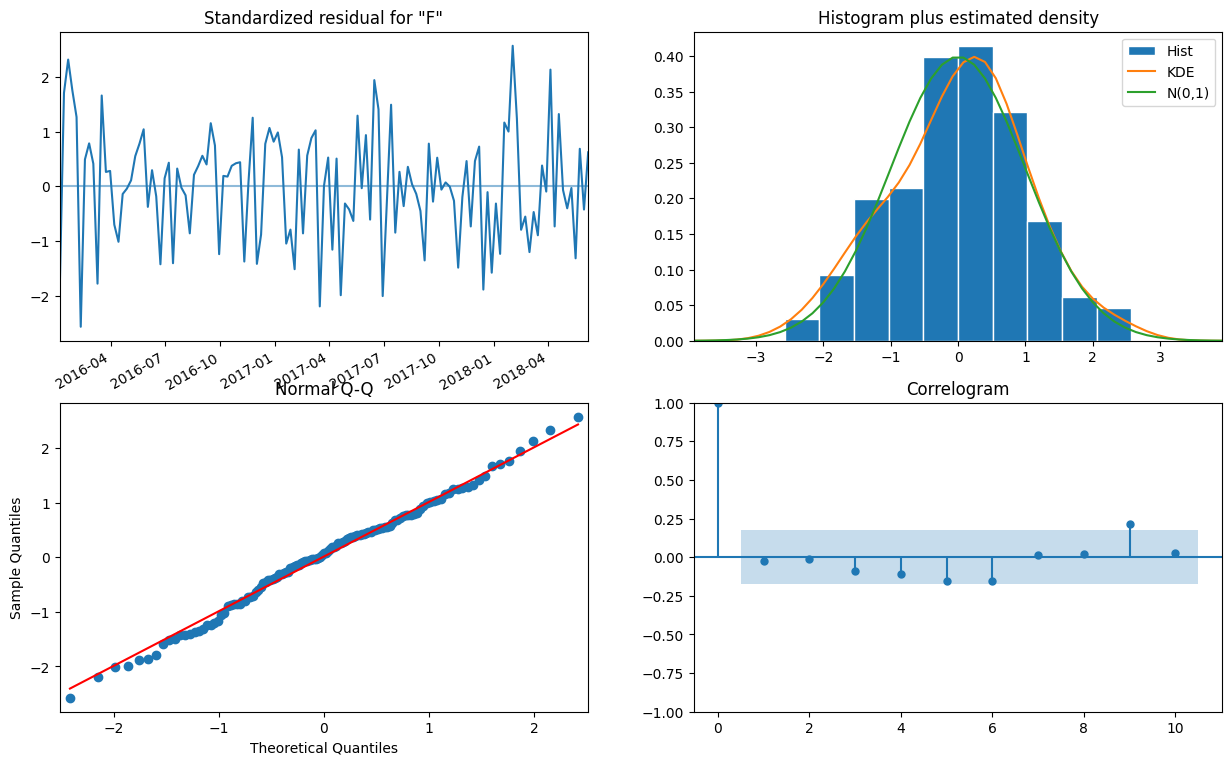

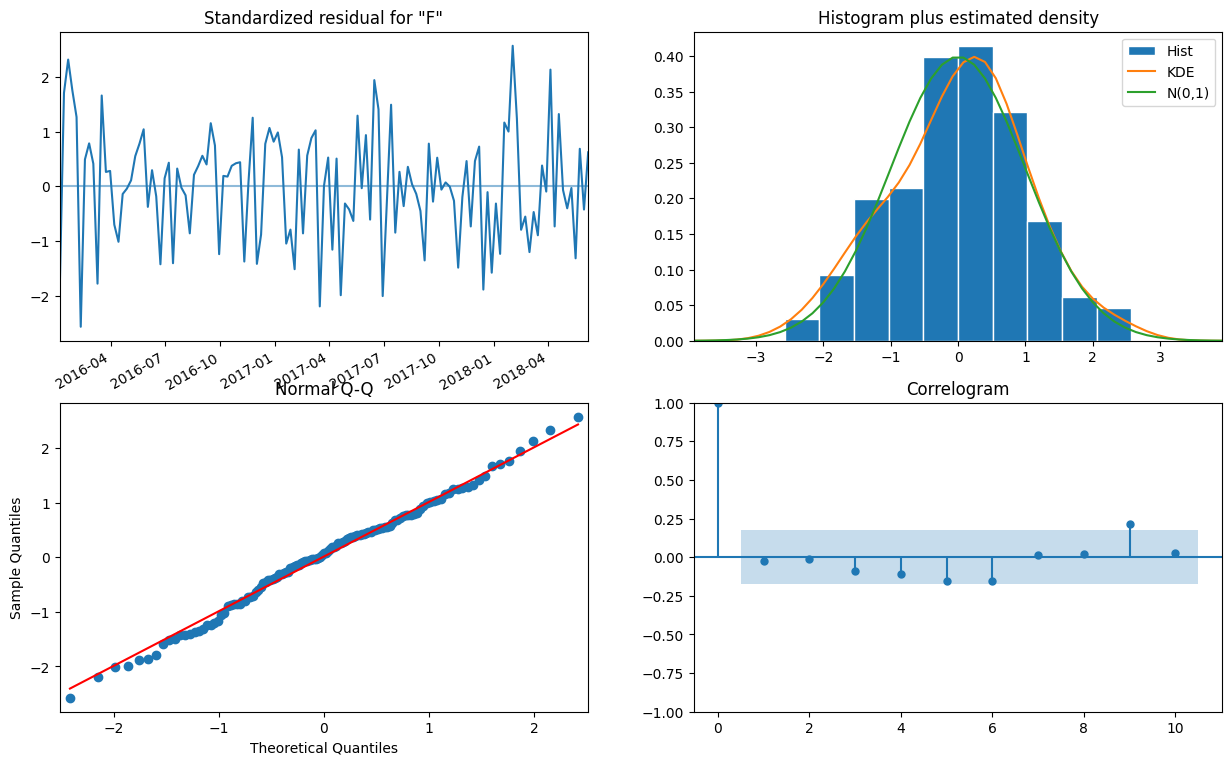

In [75]:
forecaster._fitted_forecaster.plot_diagnostics(figsize=(15, 10))

Визуализируем предсказание модели

sMAPE = 0.212


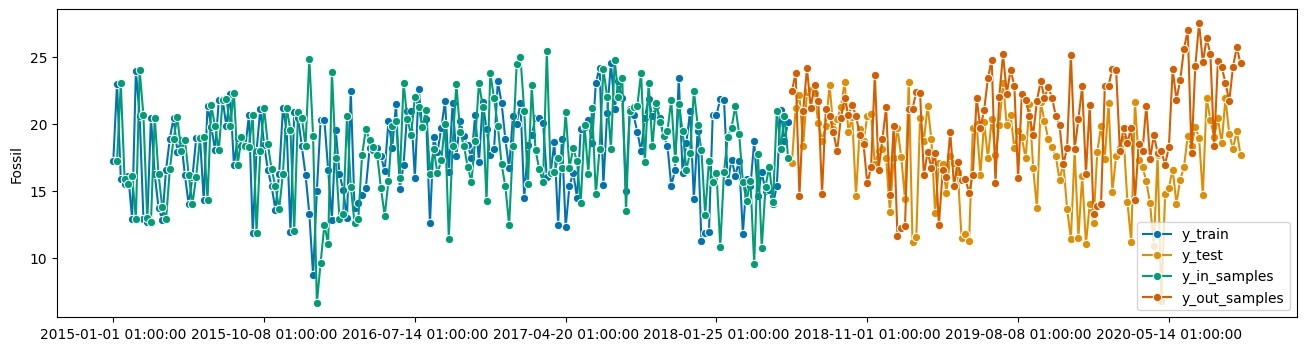

In [76]:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = forecaster.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = forecaster.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

 sMAPE = 0.280 означает, что в среднем прогнозы модели отклоняются от фактических значений на 28.0%. Попробуем улучшить предсказание применив сдвиг

sMAPE = 0.197


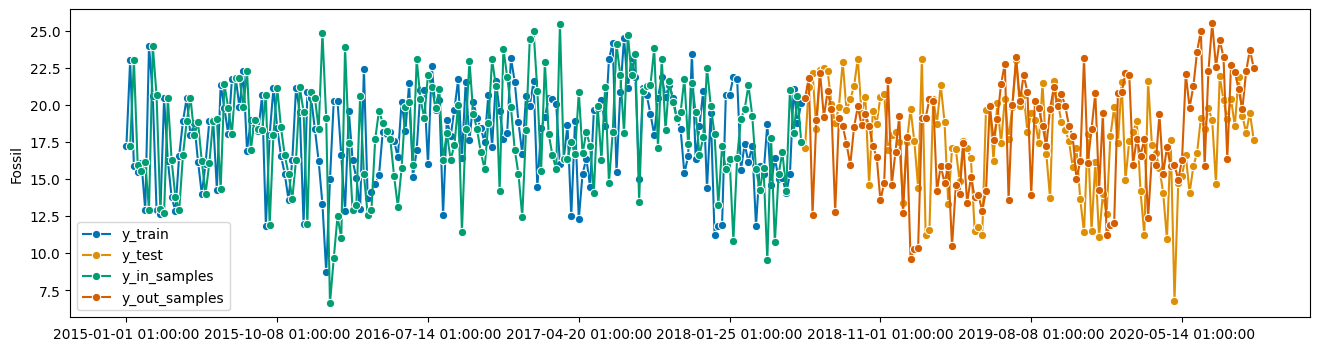

In [83]:
SHIFT = 2
y_out = forecaster.predict(fhout) - SHIFT

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

Используя небольшой сдвиг удалось улучшить предсказание до 0.143

In [53]:
model = AutoARIMA(start_p=1,  # начальный порядок AR
                  d=1,        # Порядок производной
                  start_q=0,  # начальный порядок MA
                  max_p=5,    # конечный порядок AR
                  max_q=5,    # конечный порядок MA
                  seasonal=True,  # Использовать SARIMA
                  start_P=0,  # начальный порядок SAR
                  start_Q=0,  # начальный порядок SMA
                  D=1,        # Порядок сезонной производной
                  sp=52,      # Период сезонности
                  max_order=7, # Максимальный порядок p+q+P+Q
                  trace=True,   # отчет он-лайн
                  stepwise=True, # метод ускоренного выбора параметров.
                  n_jobs =1,      # для stepwise паралельные вычисления не доступны
                  error_action='ignore',
                  suppress_warnings=True)
model.fit(y_train)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[52] intercept   : AIC=767.796, Time=0.39 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=801.005, Time=0.34 sec
 ARIMA(1,1,0)(1,1,0)[52] intercept   : AIC=750.323, Time=3.90 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=inf, Time=4.23 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=799.013, Time=0.43 sec
 ARIMA(1,1,0)(2,1,0)[52] intercept   : AIC=749.885, Time=9.42 sec
 ARIMA(1,1,0)(2,1,1)[52] intercept   : AIC=751.885, Time=11.58 sec
 ARIMA(1,1,0)(1,1,1)[52] intercept   : AIC=inf, Time=11.12 sec
 ARIMA(0,1,0)(2,1,0)[52] intercept   : AIC=inf, Time=12.43 sec
 ARIMA(2,1,0)(2,1,0)[52] intercept   : AIC=735.555, Time=19.21 sec
 ARIMA(2,1,0)(1,1,0)[52] intercept   : AIC=736.868, Time=4.80 sec
 ARIMA(2,1,0)(2,1,1)[52] intercept   : AIC=737.554, Time=14.34 sec
 ARIMA(2,1,0)(1,1,1)[52] intercept   : AIC=inf, Time=11.29 sec
 ARIMA(3,1,0)(2,1,0)[52] intercept   : AIC=724.875, Time=21.11 sec
 ARIMA(3,1,0)(1,1,0)[52] intercept   : AIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  180
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -347.877
Date:                             Sun, 24 Dec 2023   AIC                            701.754
Time:                                     00:45:59   BIC                            710.286
Sample:                                 01-01-2015   HQIC                           705.220
                                      - 06-07-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9443      0.042    -22.226      0.000      -1.028      -0.861
ar.S.L52      -0.5334      0.086     -6.230      0.000      -0.701      -0.366
sigma2        12.0066      1.686      7.120      0.000       8.701      15.312
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.82   Prob(JB):                         0.54
Heteroskedasticity (H):               0.83   Skew:                            -0.23
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

sMAPE = 0.150


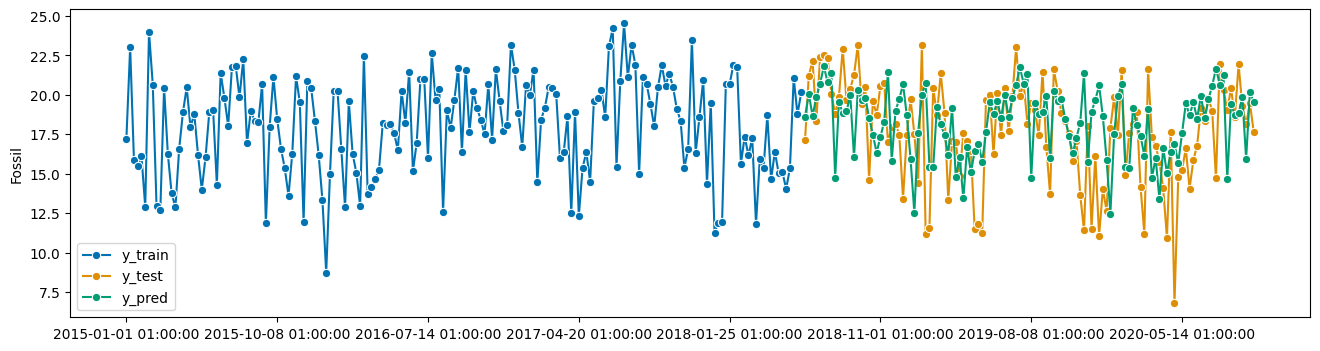

In [54]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("forecast", ARIMA( order=(1, 1, 1), seasonal_order=(0, 0, 0, 0),  )),
    ]
)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
# После удаления тренда здесь также хороший результат

Результат удалось значительно улучшить, но он всё же хуже, чем у baseline

00:46:00 - cmdstanpy - INFO - Chain [1] start processing
00:46:00 - cmdstanpy - INFO - Chain [1] done processing


sMAPE = 0.151


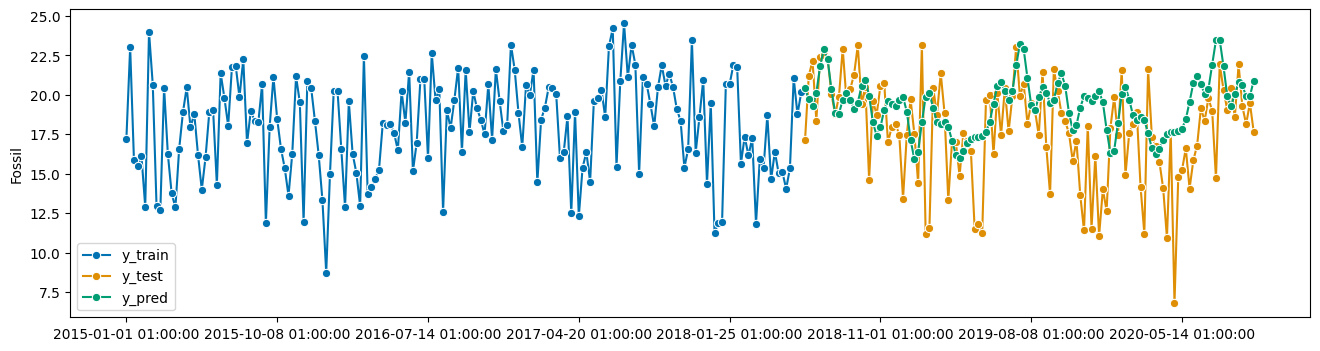

In [55]:
from sktime.forecasting.fbprophet import Prophet

forecaster = Prophet(freq='7d',
                     seasonality_mode='multiplicative',
                     add_country_holidays={'country_name': 'Spain'},
                     yearly_seasonality=True)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')